In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Layer
from keras.layers import Lambda, RepeatVector, Reshape, ZeroPadding2D
from keras.layers import Convolution2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K
from SegNet_Config import Config

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# -*- coding: utf-8 -*-
"""SegNet.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Q0SGKoouvNPDbQf9duw9GbwKuyNkNBah
"""

# Commented out IPython magic to ensure Python compatibility.

class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret
    def compute_output_shape(self, input_shape):
      mask_shape = input_shape[1]
      return (
              mask_shape[0],
              mask_shape[1]*self.size[0],
              mask_shape[2]*self.size[1],
              mask_shape[3]
              )

class Helper():
  def __init__(self):
    self.image_width = 256
    self.image_height = 256
  
  def load_Images(self,parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
    tissue_dir = parent_dir + img_folder
    gt_dir = parent_dir + gt_folder

    self.image_width, self.image_height = im_shape


    ids = next(os.walk(tissue_dir))[2]
    print("No. of images = ", len(ids))

    X = np.zeros((len(ids), self.image_height, self.image_width, 3), dtype=np.float32)
    y = np.zeros((len(ids), self.image_height, self.image_width, 1), dtype=np.float32)

    # tqdm is used to display the progress bar
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
      # Load images
      img = load_img(tissue_dir+id_)
      x_img = img_to_array(img)
      x_img = resize(x_img, (self.image_width, self.image_height, 3), mode = 'constant', preserve_range = True)
      # Load masks
      mask_id_ = id_.split('.')[0]
      mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
      if gt_extension:
        mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
      mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
      mask = resize(mask, (self.image_width, self.image_height, 1), mode = 'constant', preserve_range = True)
      # Save images
      X[n] = x_img/255.0
      y[n] = mask/255.0

    return X, y

  # Some Metrics Functions
  def dice_coefficient(self,y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

  def recall(self,y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(self,y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  ## F1 Score
  def f1_score(self,y_true, y_pred):
    presi = self.precision(y_true, y_pred)
    recall = self.recall(y_true, y_pred)
    return 2*((presi*recall)/(presi+recall+K.epsilon()))
  # Plot the learning curve
  def curve_plot(self,results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();
  
  def plot_sample(self,X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

def  buildSegnet_Architecture(
  input_shape,
  n_labels,
  kernel=3,
  pool_size=(2, 2),
  output_mode="softmax"):

  """ Encoder Layers """
  inputs = Input(shape=input_shape)

  conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
  conv_1 = BatchNormalization()(conv_1)
  conv_1 = Activation("relu")(conv_1)
  conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
  conv_2 = BatchNormalization()(conv_2)
  conv_2 = Activation("relu")(conv_2)

  pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

  conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
  conv_3 = BatchNormalization()(conv_3)
  conv_3 = Activation("relu")(conv_3)
  conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
  conv_4 = BatchNormalization()(conv_4)
  conv_4 = Activation("relu")(conv_4)

  pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

  conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
  conv_5 = BatchNormalization()(conv_5)
  conv_5 = Activation("relu")(conv_5)
  conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
  conv_6 = BatchNormalization()(conv_6)
  conv_6 = Activation("relu")(conv_6)
  conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
  conv_7 = BatchNormalization()(conv_7)
  conv_7 = Activation("relu")(conv_7)

  pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

  conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
  conv_8 = BatchNormalization()(conv_8)
  conv_8 = Activation("relu")(conv_8)
  conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
  conv_9 = BatchNormalization()(conv_9)
  conv_9 = Activation("relu")(conv_9)
  conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
  conv_10 = BatchNormalization()(conv_10)
  conv_10 = Activation("relu")(conv_10)

  pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

  unpool_2 = MaxUnpooling2D(pool_size)([pool_4, mask_4])

  conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
  conv_17 = BatchNormalization()(conv_17)
  conv_17 = Activation("relu")(conv_17)
  conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
  conv_18 = BatchNormalization()(conv_18)
  conv_18 = Activation("relu")(conv_18)
  conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
  conv_19 = BatchNormalization()(conv_19)
  conv_19 = Activation("relu")(conv_19)

  unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

  conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
  conv_20 = BatchNormalization()(conv_20)
  conv_20 = Activation("relu")(conv_20)
  conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
  conv_21 = BatchNormalization()(conv_21)
  conv_21 = Activation("relu")(conv_21)
  conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
  conv_22 = BatchNormalization()(conv_22)
  conv_22 = Activation("relu")(conv_22)

  unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

  conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
  conv_23 = BatchNormalization()(conv_23)
  conv_23 = Activation("relu")(conv_23)
  conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
  conv_24 = BatchNormalization()(conv_24)
  conv_24 = Activation("relu")(conv_24)

  unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

  conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
  conv_25 = BatchNormalization()(conv_25)
  conv_25 = Activation("relu")(conv_25)

  conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
  conv_26 = BatchNormalization()(conv_26)
  conv_26 = Reshape(
          (input_shape[0], input_shape[1], n_labels),
          input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

  outputs = Activation(output_mode)(conv_26)
  print("Decoder Architecture built...!")

  model = Model(inputs=inputs, outputs=outputs, name="SegNet")

  return model

In [3]:
!gdown https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
!unzip -q ModMonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
To: /content/ModMonuSeg.zip
224MB [00:01, 132MB/s]
replace ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
config = Config()
helper = Helper()
X, y = helper.load_Images(config.train_parent_dir, (config.im_width, config.im_height),config.img_folder, config.gt_folder, config.train_gt_extension)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
model = buildSegnet_Architecture((256,256,3), 1, kernel=3, pool_size=(2, 2), output_mode="sigmoid")
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", helper.dice_coefficient, helper.f1_score])
history=model.fit(X_train, y_train, batch_size=config.batch_size, epochs=config.epochs, callbacks=config.callbacks,
                    validation_data=(X_valid, y_valid))












Decoder Architecture built...!


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 972 samples, validate on 108 samples
Epoch 1/100
972/972 [==============================] - 108s 111ms/step - loss: 0.4864 - acc: 0.8329 - dice_coefficient: 0.5177 - f1_score: 0.7196 - val_loss: 0.4902 - val_acc: 0.8345 - val_dice_coefficient: 0.5162 - val_f1_score: 0.7222

Epoch 00001: val_loss improved from inf to 0.49017, saving model to unet-model.h5
Epoch 2/100
972/972 [==============================] - 95s 97ms/step - loss: 0.4217 - acc: 0.8658 - dice_coefficient: 0.5578 - f1_score: 0.7708 - val_loss: 0.4417 - val_acc: 0.8409 - val_dice_coefficient: 0.5298 - val_f1_score: 0.7280

Epoch 00002: val_loss improved from 0.49017 to 0.44168, saving model to unet-model.h5
Epoch 3/100
972/972 [==============================] - 94s 97ms/step - loss: 0.3816 - acc: 0.8786 - dice_coefficient: 0.5842 - f1_score: 0.7883 - val_loss: 0.4352 - val_acc

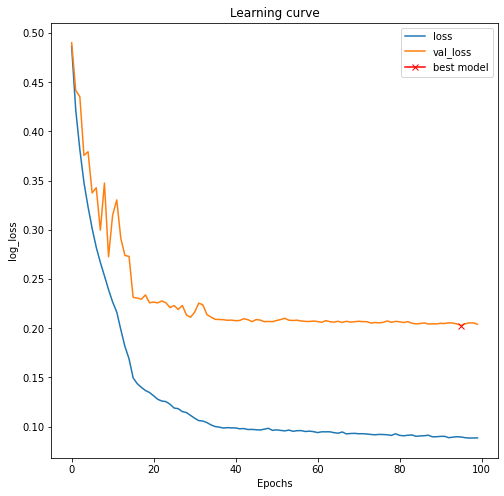

In [6]:
helper.curve_plot(history)

In [7]:
X_test, y_test = helper.load_Images(config.test_parent_dir, (config.im_width, config.im_height),
                  config.img_folder, config.gt_folder, config.test_gt_extension)
model.evaluate(X_test, y_test, verbose=1)

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



504/504 [==============================] - 28s 56ms/step


[0.27725963791211444,
 0.8978547898549882,
 0.6514035037585667,
 0.7252521041839842]

In [8]:
preds = model.predict(X_test, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

504/504 [==============================] - 25s 49ms/step


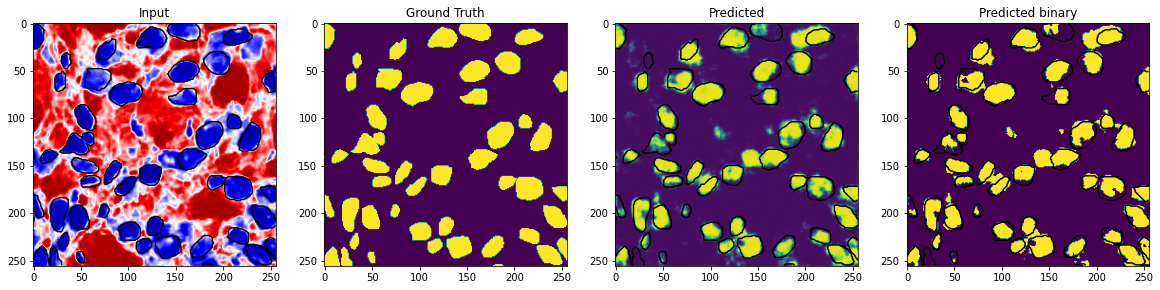

In [12]:
# Check if training data looks all right
helper.plot_sample(X_test, y_test, preds, preds_t)